# 4. Utilization Prediction

------------

In this section we predict the absolute Utilization (number of cars per hour) as well as the percentage Utilization (percentage of possible charging minutes occupied)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
charging_set_complete = pd.read_csv("data/cleaned_charging_set.csv")

In [3]:
charging_set_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31702 entries, 0 to 31701
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  31702 non-null  object 
 1   connectionTime                      31702 non-null  object 
 2   disconnectTime                      31702 non-null  object 
 3   doneChargingTime                    31702 non-null  object 
 4   kWhDelivered                        31702 non-null  float64
 5   sessionID                           31702 non-null  object 
 6   siteID                              31702 non-null  int64  
 7   spaceID                             31702 non-null  object 
 8   stationID                           31702 non-null  object 
 9   userID                              31702 non-null  float64
 10  WhPerMile                           31702 non-null  float64
 11  kWhRequested                        31702

In [4]:
weather_set = pd.read_csv("data/cleaned_weather_set.csv")

In [5]:
weather_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     29244 non-null  object 
 1   timestamp                29244 non-null  object 
 2   temperature              29219 non-null  float64
 3   cloud_cover              29224 non-null  float64
 4   cloud_cover_description  29224 non-null  object 
 5   pressure                 29236 non-null  float64
 6   windspeed                29158 non-null  float64
 7   precipitation            29244 non-null  float64
 8   felt_temperature         29218 non-null  float64
 9   temperature_difference   29218 non-null  float64
 10  date_year                29244 non-null  int64  
 11  date_month               29244 non-null  int64  
 12  date_day                 29244 non-null  int64  
 13  time                     29244 non-null  object 
 14  mostly                

In [6]:
print(weather_set["timestamp"].max(),charging_set_complete["connectionTime"].max())
print(weather_set["timestamp"].min(),charging_set_complete["connectionTime"].min())

2021-01-01 07:53:00 2021-09-14 05:43:39+00:00
2018-01-01 08:53:00 2018-04-30 15:07:49+00:00


As we can see the datasets have different time frames, whcih we have to keep in mind for merging later. Unfortunetly this means some data will be lost. 

In [7]:
# seperate data into site 1 and site 2
charging_set_site1 = charging_set_complete[charging_set_complete["siteID"] == 1]
charging_set_site2 = charging_set_complete[charging_set_complete["siteID"] == 2]

In [8]:
charging_set_site1.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture_year,requestedDeparture_month,requestedDeparture_day,requestedDeparture_time,requestedDeparture_weekday,connectionDuration,chargingDuration,connect_weekday,disconnect_weekday,chargingDone_disconnect_difference
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020.0,1.0,2.0,20:51:54,3.0,6.039167,4.378056,3,3,1.661111
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020.0,1.0,2.0,23:31:50,3.0,9.025278,6.687500,3,3,2.337778
2,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,...,2020.0,1.0,2.0,22:24:01,3.0,8.144167,4.291389,3,3,3.852778
3,5e23b149f9af8b5fe4b973d4,2020-01-02 14:00:13+00:00,2020-01-02 23:00:41+00:00,2020-01-02 20:13:21+00:00,13.370,1_1_194_821_2020-01-02 14:00:05.241573,1,AG-1F13,1-1-194-821,3519.0,...,2020.0,1.0,3.0,00:24:13,4.0,9.007778,6.218889,3,3,2.788889
4,5e23b149f9af8b5fe4b973d5,2020-01-02 14:09:14+00:00,2020-01-03 01:57:58+00:00,2020-01-03 00:59:21+00:00,43.477,1_1_178_817_2020-01-02 14:09:14.451827,1,AG-1F09,1-1-178-817,933.0,...,2020.0,1.0,3.0,00:56:14,4.0,11.812222,10.835278,3,4,0.976944


In [9]:
df_no_duplicates = charging_set_site1.drop_duplicates()

In [10]:
# check space amount of each parking site 
amount_spaces1 = charging_set_site1["spaceID"].nunique()
amount_spaces2 = charging_set_site2["spaceID"].nunique()
print(amount_spaces1,amount_spaces2)

52 53


Let's create a dataframe that contains an entry for every hour in between the first and last charging event. This will becime usefull for the prediction later, as the task is to specifically predict hourly utiliaztion.

This has to be done for Site 1 and 2. The procedure is the same so it will look redundant

In [11]:
charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])
# sort acsending
charging_set_site1 = charging_set_site1.sort_values(by='connectionTime').reset_index(drop=True)

# set min and max time 
min_time = charging_set_site1['connectionTime'].min().floor('H')
max_time = charging_set_site1['disconnectTime'].max().ceil('H')

# create df for every hour 
hours_df = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='H')})
hours_df.head()

C:\Users\adria\AppData\Local\Temp\ipykernel_8100\326624327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
C:\Users\adria\AppData\Local\Temp\ipykernel_8100\326624327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])
C:\Users\adria\AppData\Local\Temp\ipykernel_8100\326624327.py:7: FutureWarning: 'H' is deprecated and will

,hour
0,2018-10-08 13:00:00+00:00
1,2018-10-08 14:00:00+00:00
2,2018-10-08 15:00:00+00:00
3,2018-10-08 16:00:00+00:00
4,2018-10-08 17:00:00+00:00


In [12]:
charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])

# sort ascending
charging_set_site2 = charging_set_site2.sort_values(by='connectionTime').reset_index(drop=True)

# set min and max time 
min_time = charging_set_site2['connectionTime'].min().floor('H')
max_time = charging_set_site2['disconnectTime'].max().ceil('H')

# create df for every hour 
hours_df2 = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='H')})
hours_df2.head()


C:\Users\adria\AppData\Local\Temp\ipykernel_8100\4277142658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
C:\Users\adria\AppData\Local\Temp\ipykernel_8100\4277142658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])
C:\Users\adria\AppData\Local\Temp\ipykernel_8100\4277142658.py:8: FutureWarning: 'H' is deprecated and w

,hour
0,2018-04-30 15:00:00+00:00
1,2018-04-30 16:00:00+00:00
2,2018-04-30 17:00:00+00:00
3,2018-04-30 18:00:00+00:00
4,2018-04-30 19:00:00+00:00


We can see that there are different timeframes of data available for both sites. 

In [13]:
# check for duplicates to make sure df creation was succesful 
print(hours_df.duplicated().sum(), hours_df2.duplicated().sum())

0 0


In [14]:
# check for duplicates in charging sets
print(charging_set_site1.duplicated().sum(), charging_set_site2.duplicated().sum())


0 0


In [15]:
# drop duplicates we foundin site 1
charging_set_site1 = charging_set_site1.drop_duplicates()
charging_set_site1.duplicated().sum()

np.int64(0)

Now we want to create our target variables that we want to predict later. For this we create 2 values: 
- connectedCars: the number of active charging sessions for each other
- utilization: the actual number of minutes that was charged for each hour 

The utiliaztion column effectivly sums up the active charging minutes for each hour and divides that by the maximum number of minutes that could be charged. In case of sitze 1 for example that would mean 60x52 = 3120 are the max charging miinutes for this site per hour. If we divide the minutes of active sessions by this value, we get the precise percentage of the charging site utilization.

**Calculation for Site 1**

In [16]:
# number of spaces (total available spaces site 1)
total_spaces = 52

# function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site1, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # filter sessions active during this hour
    active_sessions = charging_set_site1[
        (charging_set_site1['connectionTime'] < end_of_hour) & (charging_set_site1['disconnectTime'] > start_of_hour)
    ]
    
    # calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # count number of cars
    connected_cars = len(active_sessions)
    # utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# compute utilization column
hours_df['utilization'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[0]
)

# compute connectedCars column
hours_df['connectedCars'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[1]
)

# display results
hours_df.head()

,hour,utilization,connectedCars
0,2018-10-08 13:00:00+00:00,0.008291,2
1,2018-10-08 14:00:00+00:00,0.119717,12
2,2018-10-08 15:00:00+00:00,0.230769,12
3,2018-10-08 16:00:00+00:00,0.230769,12
4,2018-10-08 17:00:00+00:00,0.230769,12


In [17]:
# number of spaces (total available spaces site 1)
total_spaces = 54

# function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site2, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # filter sessions active during this hour
    active_sessions = charging_set_site2[
        (charging_set_site2['connectionTime'] < end_of_hour) & (charging_set_site2['disconnectTime'] > start_of_hour)
    ]
    
    # calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # count number of cars
    connected_cars = len(active_sessions)
    # utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# compute utilization column
hours_df2['utilization'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[0]
)

# compute connectedCars column
hours_df2['connectedCars'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[1]
)

# display results
hours_df2.head()

,hour,utilization,connectedCars
0,2018-04-30 15:00:00+00:00,0.016106,1
1,2018-04-30 16:00:00+00:00,0.018519,1
2,2018-04-30 17:00:00+00:00,0.018519,1
3,2018-04-30 18:00:00+00:00,0.018519,1
4,2018-04-30 19:00:00+00:00,0.018519,1


In [18]:
hours_df.describe()

,utilization,connectedCars
count,25731.000000,25731.000000
mean,0.129533,7.639890
std,0.246782,13.785412
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.009621,1.000000
75%,0.111434,7.000000
max,0.980769,54.000000


In [19]:
hours_df2.describe()

,utilization,connectedCars
count,29581.000000,29581.000000
mean,0.038065,2.349515
std,0.079545,4.686455
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.035190,2.000000
max,0.518189,28.000000


---

## Merge the datasets on the timestamp columns

Merge Target Variable and Weather Dataset

In [20]:
# transform column to the same format
hours_df["hour"] = hours_df["hour"].dt.tz_localize(None)
hours_df2["hour"] = hours_df2["hour"].dt.tz_localize(None)

# convert the "timestamp" column in the weather data to datetime
weather_set["timestamp"] = pd.to_datetime(weather_set["timestamp"])

# round the weather data timestamps to the nearest hour
weather_set["timestamp"] = weather_set["timestamp"].dt.floor("H")

# merge the datasets based on the "timestamp" column
merged_data_site1 = pd.merge(hours_df, weather_set, left_on="hour", right_on="timestamp", how="left")
merged_data_site2 = pd.merge(hours_df2, weather_set, left_on="hour", right_on="timestamp", how="left")
# drop the redundant "timestamp" column from the weather data after merging
merged_data_site1 = merged_data_site1.drop(columns=["timestamp"])
merged_data_site2 = merged_data_site2.drop(columns=["timestamp"])

C:\Users\adria\AppData\Local\Temp\ipykernel_8100\1609128014.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_set["timestamp"] = weather_set["timestamp"].dt.floor("H")


In [21]:
merged_data_site1.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
0,2018-10-08 13:00:00,0.008291,2,Burbank,13.0,34.0,Fair,982.53,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-10-08 14:00:00,0.119717,12,Burbank,14.0,28.0,Mostly Cloudy,982.86,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-10-08 14:00:00,0.119717,12,Burbank,14.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-10-08 14:00:00,0.119717,12,Burbank,15.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2018-10-08 15:00:00,0.230769,12,Burbank,17.0,30.0,Partly Cloudy,983.19,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
merged_data_site2.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
0,2018-04-30 15:00:00,0.016106,1,Burbank,14.0,26.0,Cloudy,987.47,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2018-04-30 15:00:00,0.016106,1,Burbank,14.0,26.0,Cloudy,987.47,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-04-30 16:00:00,0.018519,1,Burbank,16.0,28.0,Mostly Cloudy,987.80,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-04-30 17:00:00,0.018519,1,Burbank,16.0,28.0,Mostly Cloudy,987.47,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2018-04-30 17:00:00,0.018519,1,Burbank,16.0,26.0,Cloudy,987.47,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


???? drunter weil 2 mal Site 1

In [23]:
# check dataset range
print(merged_data_site1["hour"].max(),merged_data_site1["hour"].max())

2021-09-14 15:00:00 2021-09-14 15:00:00


In [24]:
# check NaN values 
print(merged_data_site1.isna().sum(),merged_data_site2.isna().sum())

hour                          0
utilization                   0
connectedCars                 0
city                       6225
temperature                6249
cloud_cover                6244
cloud_cover_description    6244
pressure                   6225
windspeed                  6289
precipitation              6225
felt_temperature           6250
temperature_difference     6250
date_year                  6225
date_month                 6225
date_day                   6225
time                       6225
mostly                     6225
heavy                      6225
fog                        6225
windy                      6225
blowing_dust               6225
fair                       6225
haze                       6225
partly                     6225
rain                       6225
light_rain_thunder         6225
light                      6225
t-storm                    6225
thunder                    6225
thunder_in_vicinity        6225
cloudy                     6225
smoke   

In [25]:
# drop NaN values
merged_data_site1 = merged_data_site1.dropna()
merged_data_site2 = merged_data_site2.dropna()

In [26]:
# check if NaN values were dropped
print(merged_data_site1.isna().sum(),merged_data_site2.isna().sum())

hour                       0
utilization                0
connectedCars              0
city                       0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
temperature_difference     0
date_year                  0
date_month                 0
date_day                   0
time                       0
mostly                     0
heavy                      0
fog                        0
windy                      0
blowing_dust               0
fair                       0
haze                       0
partly                     0
rain                       0
light_rain_thunder         0
light                      0
t-storm                    0
thunder                    0
thunder_in_vicinity        0
cloudy                     0
smoke                      0
dtype: int64 hour                       0
utilization                0
c

In [27]:
# check max date now
print(merged_data_site1["hour"].max(),merged_data_site2["hour"].max())

2021-01-01 07:00:00 2021-01-01 07:00:00


In [28]:
# chec for duplicates
print(merged_data_site1.duplicated().sum(),merged_data_site2.duplicated().sum())

0 0


In [29]:
merged_data_site1.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,21761,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,...,21761.000000,21761.000000,21761.000000,21761.0,21761.000000,21761.000000,21761.000000,21761.0,21761.000000,21761.000000
mean,2019-11-13 08:34:33.709847552,0.145561,8.538440,17.519691,29.996094,986.936628,8.365608,0.067853,17.344883,0.202472,...,0.022379,0.085796,0.048527,0.0,0.033868,0.000919,0.000735,0.0,0.312715,0.015027
min,2018-10-08 13:00:00,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2019-04-22 03:00:00,0.000000,0.000000,13.000000,26.000000,984.500000,0.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-11-12 20:00:00,0.001026,1.000000,17.000000,33.000000,986.480000,7.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-06-01 12:00:00,0.104145,7.000000,21.000000,34.000000,989.110000,13.000000,0.000000,21.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,0.980769,54.000000,46.000000,47.000000,999.650000,57.000000,18.540000,42.000000,5.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.274405,15.270219,6.493010,5.577375,3.696341,6.761500,0.511736,6.339552,0.605198,...,0.147918,0.280069,0.214882,0.0,0.180893,0.030303,0.027106,0.0,0.463610,0.121662


In [30]:
merged_data_site2.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,25934,25934.000000,25934.000000,25934.000000,25934.000000,25934.000000,25934.000000,25934.000000,25934.000000,25934.000000,...,25934.000000,25934.000000,25934.000000,25934.0,25934.000000,25934.000000,25934.000000,25934.0,25934.000000,25934.000000
mean,2019-08-27 21:14:16.759466240,0.044430,2.725881,18.194301,30.165690,986.633502,8.581707,0.057080,18.035745,0.205984,...,0.020359,0.085910,0.041336,0.0,0.029035,0.000771,0.000733,0.0,0.319850,0.012609
min,2018-04-30 15:00:00,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2019-01-02 20:15:00,0.000000,0.000000,13.000000,26.000000,984.170000,6.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-08-22 23:30:00,0.000000,0.000000,17.000000,33.000000,986.150000,7.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-04-21 22:45:00,0.037037,2.000000,22.000000,34.000000,988.780000,13.000000,0.000000,22.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,0.518189,28.000000,46.000000,47.000000,999.650000,57.000000,18.540000,42.000000,5.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.087046,5.124984,6.534331,5.331733,3.577344,6.631221,0.469459,6.391874,0.599542,...,0.141229,0.280237,0.199069,0.0,0.167909,0.027760,0.027058,0.0,0.466427,0.111581


In [31]:
start_date = "2020-08-02"
end_date = "2020-10-31"

filtered_data = merged_data_site1.loc[
    (merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site1['hour'] <= pd.to_datetime(end_date))
]
filtered_data2 = merged_data_site2.loc[
    (merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site2['hour'] <= pd.to_datetime(end_date))
]
print(len(filtered_data),len(filtered_data2))

2281 2281


In [32]:
zero_connected_cars_count = filtered_data[filtered_data['connectedCars'] == 0].shape[0]
zero_connected_cars_count2 = filtered_data2[filtered_data2['connectedCars'] == 0].shape[0]
print(zero_connected_cars_count,zero_connected_cars_count2)

2258 2261


As we saw in the descriptive analysis (Section 2) there is a gap of data between august 2020 and Oktober 2020. This will most likely have a negativ impact on our model performance because as seen above those values are almost all 0. Therefore we are dropping them.

In [33]:
merged_data_site1 = merged_data_site1.loc[
    ~((merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site1['hour'] <= pd.to_datetime(end_date)))
]
merged_data_site2 = merged_data_site2.loc[
    ~((merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site2['hour'] <= pd.to_datetime(end_date)))
]

In [34]:
merged_data_site1.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,19480,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,...,19480.000000,19480.000000,19480.000000,19480.0,19480.000000,19480.000000,19480.000000,19480.0,19480.000000,19480.000000
mean,2019-10-08 06:59:32.833675520,0.162482,9.531109,16.781674,29.904517,987.194964,8.485575,0.075798,16.629723,0.171869,...,0.020534,0.094251,0.054055,0.0,0.037680,0.001027,0.000821,0.0,0.335164,0.004107
min,2018-10-08 13:00:00,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2019-03-31 03:45:00,0.000000,0.000000,12.000000,26.000000,984.500000,6.000000,0.000000,12.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-09-28 22:30:00,0.018301,1.000000,16.000000,33.000000,986.810000,7.000000,0.000000,16.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-03-30 07:15:00,0.154064,10.000000,21.000000,34.000000,989.770000,13.000000,0.000000,21.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,0.980769,54.000000,38.000000,47.000000,999.650000,57.000000,18.540000,37.000000,5.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.285235,15.843233,6.115738,5.668388,3.738242,6.841371,0.540312,6.022547,0.559173,...,0.141821,0.292184,0.226133,0.0,0.190425,0.032026,0.028648,0.0,0.472060,0.063954


In [35]:
merged_data_site2.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,23653,23653.000000,23653.000000,23653.000000,23653.000000,23653.000000,23653.000000,23653.000000,23653.000000,23653.000000,...,23653.000000,23653.000000,23653.000000,23653.0,23653.000000,23653.000000,23653.000000,23653.0,23653.000000,23653.000000
mean,2019-07-21 17:03:31.102185728,0.048699,2.987697,17.651545,30.106625,986.817028,8.701349,0.062585,17.513381,0.181119,...,0.018645,0.092885,0.045195,0.0,0.031708,0.000846,0.000803,0.0,0.339027,0.003382
min,2018-04-30 15:00:00,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2018-12-11 10:00:00,0.000000,0.000000,13.000000,26.000000,984.500000,6.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-07-09 13:00:00,0.015463,1.000000,17.000000,33.000000,986.480000,7.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-02-22 20:00:00,0.037037,3.000000,22.000000,34.000000,989.110000,13.000000,0.000000,22.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,0.518189,28.000000,45.000000,47.000000,999.650000,57.000000,18.540000,41.000000,5.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.090001,5.293162,6.305709,5.388701,3.621034,6.682061,0.491225,6.213617,0.561238,...,0.135269,0.290277,0.207736,0.0,0.175226,0.029067,0.028331,0.0,0.473389,0.058060


---

### Feature Engineering for Modeling

Add the features to site 1 and site 2

In [36]:
# create season column and weekend/weekday column and covvid column
merged_data_site1["hour"] = pd.to_datetime(merged_data_site1["hour"])
# add covid column
merged_data_site1["covid"] = merged_data_site1["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site1["weekday"] = merged_data_site1["hour"].apply(lambda x: x.weekday())
 
# function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# apply the season mapping
merged_data_site1["Season"] = merged_data_site1["date_month"].apply(get_season)

# add weekday/weekend column 
merged_data_site1["Weekday/Weekend"] = merged_data_site1["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site1["Season"] = merged_data_site1["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# apply the function to create a new column
merged_data_site1["time_of_day"] = merged_data_site1["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site1["hour_of_day"] = merged_data_site1["hour"].dt.hour

# resulting DataFrame
merged_data_site1.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-10-08 13:00:00,0.008291,2,Burbank,13.0,34.0,Fair,982.53,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,3,0,2,13
1,2018-10-08 14:00:00,0.119717,12,Burbank,14.0,28.0,Mostly Cloudy,982.86,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,14
2,2018-10-08 14:00:00,0.119717,12,Burbank,14.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,14
3,2018-10-08 14:00:00,0.119717,12,Burbank,15.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,14
4,2018-10-08 15:00:00,0.230769,12,Burbank,17.0,30.0,Partly Cloudy,983.19,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,15


In [37]:
# create season column and weekend/weekday column and covvid column
merged_data_site2["hour"] = pd.to_datetime(merged_data_site2["hour"])
# add covid column
merged_data_site2["covid"] = merged_data_site2["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site2["weekday"] = merged_data_site2["hour"].apply(lambda x: x.weekday())
 
# function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# apply the season mapping
merged_data_site2["Season"] = merged_data_site2["date_month"].apply(get_season)

# add weekday/weekend column 
merged_data_site2["Weekday/Weekend"] = merged_data_site2["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site2["Season"] = merged_data_site2["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# apply the function to create a new column
merged_data_site2["time_of_day"] = merged_data_site2["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site2["hour_of_day"] = merged_data_site2["hour"].dt.hour
# resulting DataFrame
merged_data_site2.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-04-30 15:00:00,0.016106,1,Burbank,14.0,26.0,Cloudy,987.47,13.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,0,2,15
1,2018-04-30 15:00:00,0.016106,1,Burbank,14.0,26.0,Cloudy,987.47,9.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,0,2,15
2,2018-04-30 16:00:00,0.018519,1,Burbank,16.0,28.0,Mostly Cloudy,987.80,11.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,0,2,16
3,2018-04-30 17:00:00,0.018519,1,Burbank,16.0,28.0,Mostly Cloudy,987.47,9.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,0,2,17
4,2018-04-30 17:00:00,0.018519,1,Burbank,16.0,26.0,Cloudy,987.47,9.0,0.0,...,0.0,0.0,1.0,0.0,0,0,1,0,2,17


### Feature Selection

Site 1:

In [38]:
# compute correlation matrix
correlation_matrix = merged_data_site1.corr()

# correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)

ValueError: could not convert string to float: 'Burbank'

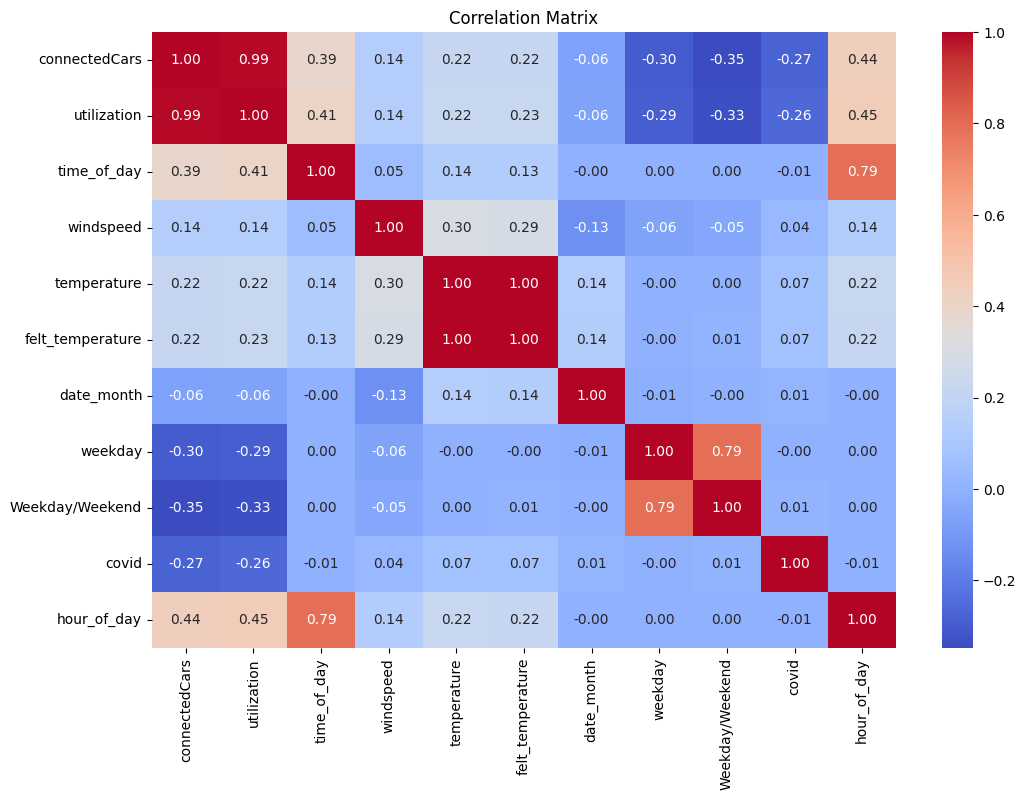

In [39]:
# compute correlation and display correlation for newly selected features
predictionDF_site1 = merged_data_site1[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site1.corr()
# plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Site 2:

In [40]:
# compute correlation matrix
correlation_matrix = merged_data_site2.corr()


# correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)

ValueError: could not convert string to float: 'Burbank'

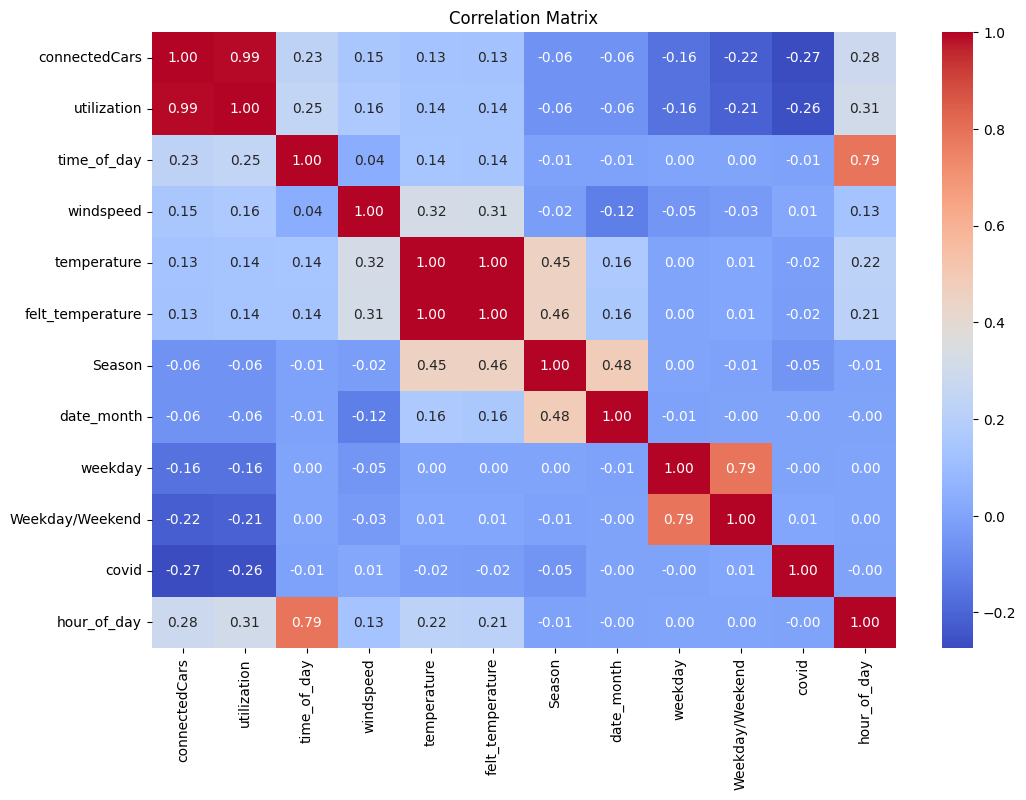

In [41]:
# compute correlation and display correlation for newly selected features
predictionDF_site2 = merged_data_site2[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","Season","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site2.corr()
# plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---

### Prediction

### Random Forest 

Random Forest for Site 1, connectedCars

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site1[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]] # Features
y = predictionDF_site1['connectedCars']  # Target variable

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 2.613821204491379
R-squared (R2): 0.8512988413657604


Random Forest for Site 2, connectedCars

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site2[["hour_of_day","covid","Weekday/Weekend","weekday","Season","temperature","windspeed"]]
y = predictionDF_site2['connectedCars']  

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 1.8793738415052619
R-squared (R2): 0.5838615411451225


Random Forest for Site 1 Utilization

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site1[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]] # Features
y = predictionDF_site1['utilization']  # Target variable

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 0.045209949708862385
R-squared (R2): 0.8544375960980667


Random Forest for Site 2 Utilization

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site2[["hour_of_day","covid","Weekday/Weekend","weekday","Season","temperature","windspeed"]]
y = predictionDF_site2['utilization']  

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 0.030991454485630874
R-squared (R2): 0.5901346776801503


### Neural Network

#### ConnectedCars Prediction for Site 1 with Neural Network

In [46]:
X = predictionDF_site1.copy()
X = predictionDF_site1.drop(["connectedCars","utilization","temperature","time_of_day"],axis = 1)
y = predictionDF_site1[["connectedCars"]]

In [47]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19480 entries, 0 to 21940
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   connectedCars  19480 non-null  int64
dtypes: int64(1)
memory usage: 304.4 KB


In [48]:
X.head()

,windspeed,felt_temperature,date_month,weekday,Weekday/Weekend,covid,hour_of_day
0,0.0,13.0,10.0,0,0,0,13
1,0.0,14.0,10.0,0,0,0,14
2,0.0,14.0,10.0,0,0,0,14
3,0.0,15.0,10.0,0,0,0,14
4,0.0,17.0,10.0,0,0,0,15


In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19480 entries, 0 to 21940
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   windspeed         19480 non-null  float64
 1   felt_temperature  19480 non-null  float64
 2   date_month        19480 non-null  float64
 3   weekday           19480 non-null  int64  
 4   Weekday/Weekend   19480 non-null  int64  
 5   covid             19480 non-null  int64  
 6   hour_of_day       19480 non-null  int32  
dtypes: float64(3), int32(1), int64(3)
memory usage: 1.1 MB


In [50]:
X.isna().sum()

windspeed           0
felt_temperature    0
date_month          0
weekday             0
Weekday/Weekend     0
covid               0
hour_of_day         0
dtype: int64

In [51]:
X = X.dropna()
y = y.dropna()

In [52]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
# initialise model
model = Sequential(
    [Dense(160, activation="relu", input_shape=[X_train.shape[1]]),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
     Dense(32, activation="relu"),
      Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
     Dense(1)])

c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
# compile model
model.compile(optimizer="adam", loss = "mean_squared_error",
             metrics=["mae"])

In [55]:
# train model
epochs = 65

history = model.fit(X_train, y_train.values,
                   epochs=epochs, validation_split=0.3)

Epoch 1/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 162.9556 - mae: 7.4325 - val_loss: 61.0871 - val_mae: 4.2086
Epoch 2/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 57.9776 - mae: 4.0914 - val_loss: 50.6549 - val_mae: 3.7048
Epoch 3/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 45.9858 - mae: 3.5372 - val_loss: 46.1940 - val_mae: 3.4675
Epoch 4/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 44.6489 - mae: 3.4174 - val_loss: 47.9076 - val_mae: 3.2894
Epoch 5/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 42.1592 - mae: 3.3487 - val_loss: 51.8207 - val_mae: 3.4301
Epoch 6/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.9001 - mae: 3.2251 - val_loss: 48.0895 - val_mae: 3.3034
Epoch 7/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 43.3081 - mae: 3.2755 - val_loss: 54.9602 - val_mae: 3.9202
Epoch 8/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.4652 - mae: 3.1837 - val_loss: 42.1273 - val_mae: 3.1274
Epoch 9/65
299/299 ━━━━━━━━━━━━━━━━━━━━

In [56]:
# make predictions
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [57]:
print(r2)

0.8512142300605774


In [58]:
# evaluating the model on test data
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35.7076 - mae: 2.7516
Test Loss: 37.68496322631836, Test MAE: 2.8009278774261475


#### Connected Cars Prediction for Site 2

In [62]:
X = predictionDF_site2[["hour_of_day","covid","Weekday/Weekend","weekday","Season","temperature","windspeed"]]
y = predictionDF_site2[["connectedCars"]]

In [59]:
X.head()

,windspeed,felt_temperature,date_month,weekday,Weekday/Weekend,covid,hour_of_day
0,0.0,13.0,10.0,0,0,0,13
1,0.0,14.0,10.0,0,0,0,14
2,0.0,14.0,10.0,0,0,0,14
3,0.0,15.0,10.0,0,0,0,14
4,0.0,17.0,10.0,0,0,0,15


In [60]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19480 entries, 0 to 21940
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   connectedCars  19480 non-null  int64
dtypes: int64(1)
memory usage: 304.4 KB


In [61]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [63]:
# initialise model
model = Sequential(
    [Dense(160, activation="relu", input_shape=[X_train.shape[1]]),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
     Dense(32, activation="relu"),
      Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
     Dense(1)])

c:\Users\adria\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
# compile model
model.compile(optimizer="adam", loss = "mean_squared_error",
             metrics=["mae"])

In [65]:
# train model
epochs = 65

history = model.fit(X_train, y_train.values,
                   epochs=epochs, validation_split=0.3)

Epoch 1/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 190.7117 - mae: 8.1714 - val_loss: 66.8394 - val_mae: 4.6852
Epoch 2/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 60.9929 - mae: 4.4361 - val_loss: 49.7518 - val_mae: 3.5436
Epoch 3/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 47.4382 - mae: 3.6115 - val_loss: 49.1706 - val_mae: 3.4614
Epoch 4/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 45.7159 - mae: 3.5130 - val_loss: 52.8523 - val_mae: 3.4978
Epoch 5/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 43.6574 - mae: 3.3676 - val_loss: 49.7866 - val_mae: 3.3115
Epoch 6/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 41.3850 - mae: 3.1569 - val_loss: 45.5513 - val_mae: 3.0737
Epoch 7/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 37.4751 - mae: 3.0578 - val_loss: 43.8073 - val_mae: 3.0903
Epoch 8/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.8121 - mae: 3.1357 - val_loss: 43.2929 - val_mae: 3.0859
Epoch 9/65
299/299 ━━━━━━━━━━━━━━━━━━━━

In [66]:
# make predictions
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [67]:
print(r2)

0.8323939442634583


In [68]:
# evaluating the model on test data
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.2579 - mae: 2.8680
Test Loss: 42.45183563232422, Test MAE: 2.938389778137207
